# Simulating Respondent Driven Sampling

In [1]:
#https://networkx.github.io/documentation/networkx-1.9/_modules/networkx/generators/random_graphs.html

In [2]:
import itertools
import random
import math
import networkx as nx
import statistics
import numpy as np
import pandas as pd
import collections
import matplotlib.pyplot as plt
from networkx.generators.classic import empty_graph, path_graph, complete_graph

from collections import defaultdict

__all__ = ['fast_gnp_random_graph']

%matplotlib inline

### Create an undirected network with 10,000 nodes; 0.2% probability of edge creation. 

In [3]:
def fast_gnp_random_graph(n, p, seed=None, directed=False):
    """Return a multi directed graph G_{n,p} (Erdős-Rényi graph, binomial graph).

    Parameters
    ----------
    n : int
        The number of nodes.
    p : float
        Probability for edge creation.
    seed : int, optional
        Seed for random number generator (default=None).
    directed : bool, optional (default=False)
        If True return a directed graph

    Notes
    -----
    The G_{n,p} graph algorithm chooses each of the [n(n-1)]/2
    (undirected) or n(n-1) (directed) possible edges with probability p.

    This algorithm is O(n+m) where m is the expected number of
    edges m=p*n*(n-1)/2.

    It should be faster than gnp_random_graph when p is small and
    the expected number of edges is small (sparse graph).

    See Also
    --------
    gnp_random_graph

    References
    ----------
    .. [1] Vladimir Batagelj and Ulrik Brandes,
       "Efficient generation of large random networks",
       Phys. Rev. E, 71, 036113, 2005.
    """
    G = empty_graph(n)
    G.name="fast_gnp_random_graph(%s,%s)"%(n,p)

    if not seed is None:
        random.seed(seed)

    if p <= 0 or p >= 1:
        return nx.gnp_random_graph(n,p,directed=directed)

    w = -1
    lp = math.log(1.0 - p)

    if directed:
        G = nx.MultiDiGraph(G)
        # Nodes in graph are from 0,n-1 (start with v as the first node index).
        v = 0
        while v < n:
            lr = math.log(1.0 - random.random())
            w = w + 1 + int(lr/lp)
            if v == w: # avoid self loops
                w = w + 1
            while  w >= n and v < n:
                w = w - n
                v = v + 1
                if v == w: # avoid self loops
                    w = w + 1
            if v < n:
                G.add_edge(v, w)
    else:
        # Nodes in graph are from 0,n-1 (start with v as the second node index).
        v = 1
        while v < n:
            lr = math.log(1.0 - random.random())
            w = w + 1 + int(lr/lp)
            while w >= v and v < n:
                w = w - v
                v = v + 1
            if v < n:
                G.add_edge(v, w)
    return G

G = fast_gnp_random_graph(10000, 0.002, 1, directed = False)

### Double check the average node degree is roughly 20 for the network.

In [4]:
statistics.mean(dict(G.degree()).values())

19.9254

### Randomly assign a trait to all of the nodes in the network. 

In [28]:
def assign_trait(graph, proportion):
    '''Graph = networkx graph
       Proportion = float between 0.0 and 1.0 for the proportion with a given trait'''
    
    # list of length of nodes in Graph with key/value pairs for having trait or not at specified proportion
    trait_list = [{'trait':1} for i in range(int(proportion*len(graph)))]
    trait_list += [{'trait':0} for i in range(int(len(graph) - proportion*len(graph)))]
    random.shuffle(trait_list)

    nx.set_node_attributes(graph, dict(enumerate(trait_list)))
    
assign_trait(graph = G, proportion = 0.65)

### Create a seed sample from the population with a specified proportion of nodes with a given trait

In [29]:
def sample_from_graph(graph, proportion, trait, size):
    '''Graph is the networkx graph you are sampling from, Proportion is a float between 0.0 and 1.0 for the intended
    proportion of the trait in the sample, Trait is a String and is the trait you are interested in, Size is an int for the 
    amount of nodes in sample.'''
    
    # Separate subgraphs; with and without trait
    subgraph_with_trait = graph.subgraph([key for key, value in nx.get_node_attributes(graph, trait).items() if value == 1])
    subgraph_no_trait = graph.subgraph([key for key, value in nx.get_node_attributes(graph, trait).items() if value == 0])

    # Sample from subgraphs @ given proportion
    sample_with_trait = graph.subgraph(random.sample(subgraph_with_trait.nodes, int(proportion*size)))
    sample_no_trait = graph.subgraph(random.sample(subgraph_no_trait.nodes, (size-int(proportion*size))))

    return nx.compose(sample_with_trait, sample_no_trait)

seed_sample = sample_from_graph(G, 0.65, 'trait', 150)

# Case 1: All men and women refer within gender 80% of the time.

This chain sampling algorithm does the following:
1. For each node in the seed sample:
    
    a. Check gender. 
        1. Continue to referral step depending on gender (65% and 47% probability M/F respectively will proceed). 
    b. Given this node is going to refer, for each of their contacts in G, check gender.
        1. For each node/nodes contact pair, if they are the same gender: 80% chance they will be referred, 20% chance they will not be referred. 

2. For each wave of sampling, record the proportion of females in the current sample. 
        
Notes: each node will refer a different number of contacts based on 
1. Their number of contacts in G
2. Their gender

i.e. more connected men will refer more contacts, on average, than less connected women given the probabilities from pilot2.

### Functions needed to perform the chain sampling

In [45]:
def trait_proportion(graph):
    '''graph is the networkx graph, trait is a string for the trait of interest
       returns the percentage of nodes in the graph with specified trait (0-100).'''
    return list(nx.get_node_attributes(graph, 'trait').values()).count(1) \
             / len(list(nx.get_node_attributes(seed_sample, 'trait').values()))*100

In [52]:
results_df = pd.DataFrame([[0,trait_proportion(seed_sample)]], columns=['sampling_wave', 'percent_female'])

In [30]:
def chain_sample(seed, waves, current_sample= 0, checker = 1, results_df = None):
    ''' seed is the starting sample
        waves is number of waves for iterating
        This function runs chain sampling and updates table with results for each wave'''

    if checker > waves:
        return
    
    elif current_sample == 0:
        
        #initialize a dataframe to record results
        results_df = pd.DataFrame([[0,trait_proportion(seed)]], columns=['sampling_wave', 'percent_female'])
        
        current_sample = G.subgraph(random.sample(list(seed.nodes()), k=random.choice(range(int(len(seed_sample.nodes())/4), int(3*len(seed_sample.nodes())/4)))))
        
        #update results table
        results_df.loc[len(results)] = [checker,
                                     list(nx.get_node_attributes(current_sample, 'trait').values()).count(1)/len(list(nx.get_node_attributes(current_sample, 'trait').values()))*100]
        
        #recursively run sample
        chain_sample(seed, waves, current_sample, sum([1, checker]), results)
        return results_df
    else:
        #dictionary with key/value as node/list of contacts in G
        contacts_list_of_list = []
        for i in list(sample.nodes()):
            contacts_list_of_list.append((list(G.neighbors(i))))
        contacts_dict = dict(zip(list(sample.nodes()), contacts_list_of_list))

        #for each node in new sample, 47% chance for women and 65% chance for men to refer contacts @ p=0.8 within gender 
        put=[]
        for i in range(len(list(nx.get_node_attributes(seed_sample, 'trait')))):
            if list(nx.get_node_attributes(seed_sample, 'trait').values())[i] == 1: # if female then...
                if int(np.random.choice([0,1], 1, p = [0.53, 0.47])) == 1: # 47% chance women provide referrals...
                    for j in range(len(list(G.neighbors(i)))):
                        if nx.get_node_attributes(G, "trait")[list(G.neighbors(i))[j]] == 1: #if female 80% chance to add to list
                            put.append(list(np.random.choice([None, list(G.neighbors(i))[j]], 1, p=[0.2, 0.8])))
                        else: #if male 20% chance to add to list
                            put.append(list(np.random.choice([None, list(G.neighbors(i))[j]], 1, p=[0.8, 0.2])))
            else: # if male then...
                if int(np.random.choice([0,1], 1, p = [0.35, 0.65])) == 1: # 65% chance men provide referrals...
                    for j in range(len(list(G.neighbors(i)))): 
                        if nx.get_node_attributes(G, "trait")[list(G.neighbors(i))[j]] == 0: #if male 80% chance to add to list
                            put.append(list(np.random.choice([None, list(G.neighbors(i))[j]], 1, p=[0.2, 0.8])))
                        else: #if female 20% chance to add to list
                            put.append(list(np.random.choice([None, list(G.neighbors(i))[j]], 1, p=[0.8, 0.2])))

        # remove reduncancies and None values from list
        flat_list = [item for sublist in put for item in sublist]
        res = []
        for i in flat_list:
            if i not in res and i != None:
                res.append(i)

                
        # update current sample with new res list
        current_sample = nx.subgraph(G, res)
        
        
        #update results table
        results_df.loc[len(results)] = [checker, 
                                     list(nx.get_node_attributes(current_sample, 'trait').values()).count(1)/len(list(nx.get_node_attributes(current_sample, 'trait').values()))*100]
        
        #recursively run sample
        chain_sample(seed, waves, current_sample, sum([1, checker]), results)

In [31]:
data = pd.DataFrame([[0,list(nx.get_node_attributes(seed_sample, 'trait').values()).count(1)/len(list(nx.get_node_attributes(seed_sample, 'trait').values()))*100]], columns=['sampling_wave', 'percent_female'])

In [32]:
data.head()

,sampling_wave,percent_female
0,0,64.666667


In [19]:
# #for each node in new sample, randomly refer contacts then compile a total list
#         output = []
#         for i in list(contacts_dict.keys()):
#             if contacts_dict[i] != []:
#                 output.append(random.sample(contacts_dict[i], k=random.choice(range(len(contacts_dict[i])))))
#         output = sorted(list(x for l in output for x in l))
#         current_sample = nx.subgraph(G, output)

In [21]:
df = chain_sample(seed_sample, 50)

pandas.core.frame.DataFrame

In [23]:
#get seed_sample proportions for trait A
a_pop = list(nx.get_node_attributes(G, 'trait').values()).count(1)/len(list(nx.get_node_attributes(G, 'trait').values()))
print('Population percentage with trait: ')
print([a_pop])
pop_list = [a_pop]
a_proportion = list(nx.get_node_attributes(seed_sample, 'trait').values()).count(1)/len(list(nx.get_node_attributes(seed_sample, 'trait').values()))
print('Seed sample percentage with trait: ')
print([a_proportion])

Population percentage with trait: 
[0.65]
Seed sample percentage with trait: 
[0.6466666666666666]


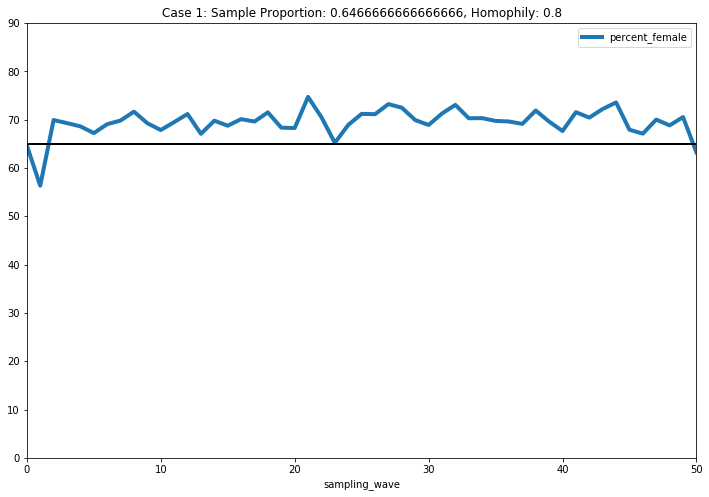

In [24]:
# visualiz results table
fig = df.plot(x='sampling_wave', figsize=(12,8), yticks=np.arange(0,100,10), lw=4, title= 'Case 1: Sample Proportion: {}, Homophily: 0.8'.format(a_proportion))
for i in pop_list:
    fig = plt.axhline(y=i*100, color='black', linestyle='-', lw=2)

In [ ]:
df.describe()

### Chain sampling from a seed sample. Referrals assume an 80% trait homophily.

In [ ]:
def chain_sample(graph, seed_sample, waves, current_sample = 0, checker = 1, results = None):
    ''' graph is the population graph 
        seed_sample is the starting sample
        waves is number of waves for iterating
        This function runs chain sampling over the specified number of waves and results in 
        a dataframe that records the wave number and the sample proportion with the trait for each wave.'''
    
    
    
    